# YOLO + FastSAM 세그멘테이션 데모

이 노트북은 TomatoVision 파이프라인의 핵심 기능인 **YOLO 객체 탐지 + FastSAM 세그멘테이션**을 시연합니다.

## 파이프라인 흐름
1. **이미지 입력** → RGB 이미지 로드
2. **YOLO 탐지** → 토마토 객체 바운딩박스 추출
3. **FastSAM 세그멘테이션** → 바운딩박스 영역 내 정밀한 마스크 생성
4. **이진 마스크 출력** → 최종 세그멘테이션 결과


In [1]:
# 필요한 라이브러리 import
import autorootcwd
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from ultralytics import FastSAM

# 설정
image_path = "data/notebook_data/tomato_image.jpg"
yolo_model_path = "weight/trained_yolo12n.pt"  # 학습된 YOLO 모델
fastsam_model_path = "weight/FastSAM-s.pt"  # FastSAM 모델
conf_thres = 0.5  # YOLO 신뢰도 임계값

# 디바이스 설정
device = 0 if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


Device: 0


## 1단계: 모델 로드


In [2]:
# YOLO 모델 로드
yolo_model = YOLO(yolo_model_path)

# FastSAM 모델 로드
fastsam_model = FastSAM(fastsam_model_path)


## 2단계: 이미지 로드 및 확인


In [3]:
# 이미지 로드
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"이미지 파일을 열 수 없습니다: {image_path}")

# 이미지 정보 가져오기
height, width = image.shape[:2]
print(f"Image size: {width}x{height}")


Image size: 3120x4160


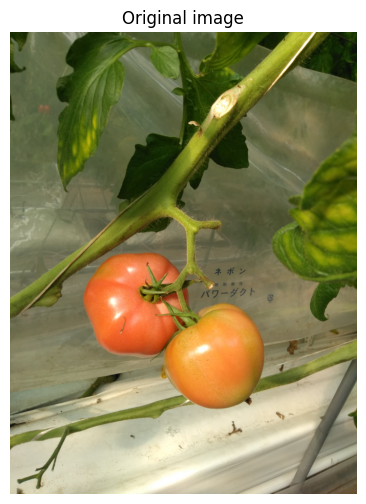

In [4]:
# BGR → RGB 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 원본 이미지 확인
plt.figure(figsize=(12, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Original image')
plt.show()


## 3단계: YOLO로 객체 감지


Detected tomatoes: 2


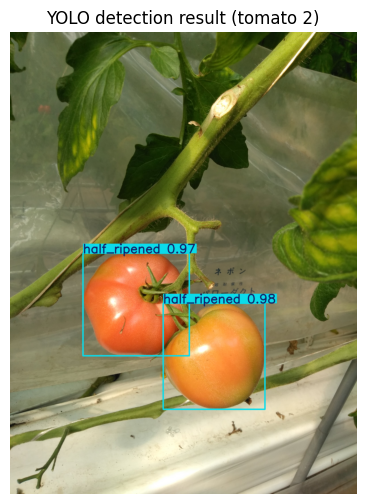

In [5]:
# YOLO로 토마토 객체 탐지
yolo_results = yolo_model(image_path, conf=conf_thres, imgsz=640, verbose=False)
yolo_result = yolo_results[0]

# 토마토 클래스 필터링
tomato_class_names = ['fully_ripened', 'half_ripened', 'green']
tomato_indices = []
tomato_boxes = []

if yolo_result.boxes is not None and len(yolo_result.boxes) > 0:
    for idx, box in enumerate(yolo_result.boxes):
        cls_id = int(box.cls[0])
        cls_name = yolo_model.names[cls_id]
        
        if cls_name in tomato_class_names:
            tomato_indices.append(idx)
            tomato_boxes.append(box.xyxy[0])
    
    # 토마토 박스 좌표 추출
    if len(tomato_boxes) > 0:
        yolo_box_coords = torch.stack(tomato_boxes)
        print(f"Detected tomatoes: {len(tomato_indices)}")
    else:
        yolo_box_coords = None
        print("No tomatoes detected")
else:
    yolo_box_coords = None
    print("No objects detected")

# 시각화
if len(tomato_indices) > 0:
    filtered_boxes = yolo_result.boxes[tomato_indices]
    yolo_annotated = yolo_result.plot(boxes=filtered_boxes)
    if yolo_annotated.shape[2] == 3:
        yolo_annotated = cv2.cvtColor(yolo_annotated, cv2.COLOR_BGR2RGB)
else:
    yolo_annotated = image_rgb.copy()

plt.figure(figsize=(12, 6))
plt.imshow(yolo_annotated)
plt.axis('off')
plt.title(f'YOLO detection result (tomato {len(tomato_indices)})')
plt.show()


## 4단계: FastSAM 세그멘테이션


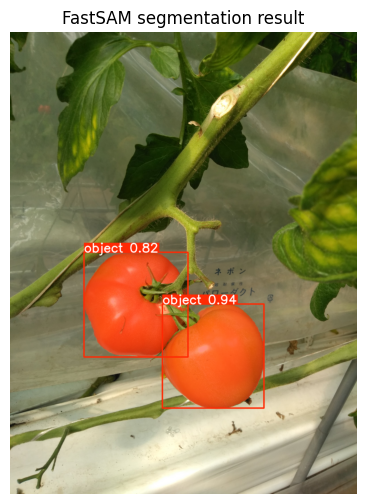

Segmentation masks: 2


In [6]:
# YOLO로 감지된 바운딩박스 영역에서 FastSAM으로 정밀한 세그멘테이션 수행
if yolo_box_coords is not None and len(yolo_box_coords) > 0:
    fastsam_results = fastsam_model.predict(
        source=image_rgb,
        bboxes=yolo_box_coords,
        device=device,
        retina_masks=True,  # 고해상도 마스크
        imgsz=640,
        conf=0.5,
        iou=0.9,
        verbose=False
    )
    
    # 결과 시각화
    annotated_image = fastsam_results[0].plot()
    
    plt.figure(figsize=(12, 6))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title('FastSAM segmentation result')
    plt.show()
    
    print(f"Segmentation masks: {len(fastsam_results[0].masks) if fastsam_results[0].masks is not None else 0}")
else:
    fastsam_results = None


## 5단계: 이진 마스크 생성


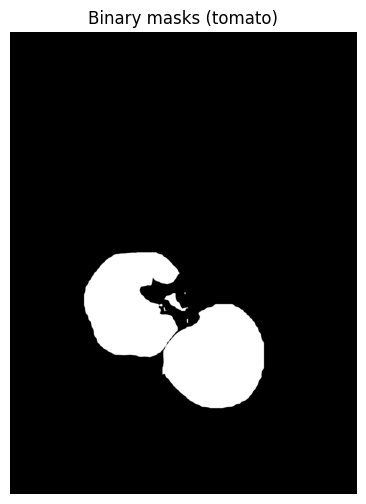

In [7]:
# FastSAM 마스크를 이진 마스크로 변환
if fastsam_results is not None:
    # 마스크 데이터 추출
    masks = fastsam_results[0].masks.data.cpu().numpy()
    
    # 여러 마스크가 있는 경우 합치기 (OR 연산)
    if len(masks.shape) >= 2:
        binary_mask = np.any(masks > 0, axis=0)
    else:
        binary_mask = masks > 0
    
    # 이진 마스크를 uint8로 변환 (0 또는 255)
    binary_image = (binary_mask * 255).astype(np.uint8)
    
    # 원본 이미지 크기로 리사이즈 (필요한 경우)
    if binary_image.shape != (height, width):
        binary_image = cv2.resize(binary_image, (width, height), interpolation=cv2.INTER_NEAREST)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')
    plt.title('Binary masks (tomato)')
    plt.show()
else:
    binary_image = np.zeros((height, width), dtype=np.uint8)


## 6단계: 최종 결과 비교


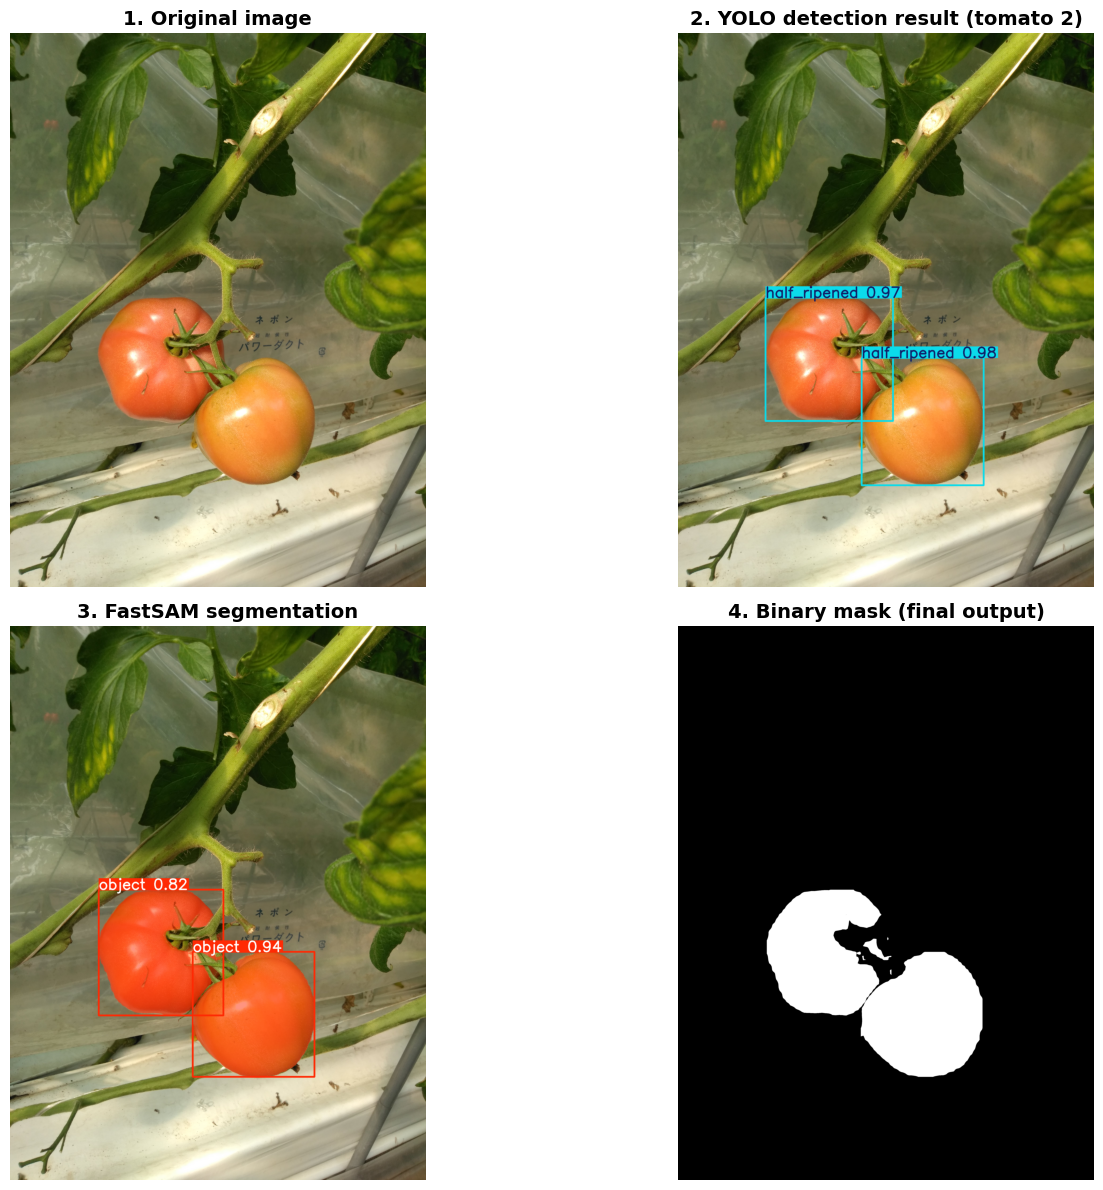

In [8]:
# 파이프라인 전체 결과를 한 번에 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 원본 이미지
axes[0, 0].imshow(image_rgb)
axes[0, 0].set_title('1. Original image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. YOLO 탐지 결과
axes[0, 1].imshow(yolo_annotated)
axes[0, 1].set_title(f'2. YOLO detection result (tomato {len(tomato_indices)})', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. FastSAM 세그멘테이션 결과
if fastsam_results is not None:
    annotated_image = fastsam_results[0].plot()
    axes[1, 0].imshow(annotated_image)
    axes[1, 0].set_title('3. FastSAM segmentation', fontsize=14, fontweight='bold')
else:
    axes[1, 0].imshow(image_rgb)
    axes[1, 0].set_title('3. FastSAM segmentation (No tomato detected)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 4. 이진 마스크 (최종 출력)
axes[1, 1].imshow(binary_image, cmap='gray')
axes[1, 1].set_title('4. Binary mask (final output)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
